## Lecture 6

#### Goals
* Analyze the invariances provided (and not provided) by the Harris corner detector
* Understand the mathematical framework for (linear) geometric transformations on images (image warping).
* Know what is possible with 2D linear transformations (scale, shear, rotation)
* Understand the motivation and math behind homogeneous coordinates.
* Know what is possible with 2D affine transformations (all of the above, plus translation)

* Understand the concept of invariance as pertains to feature detectors and feature descriptors
* Know the how and why of the MOPS feature descriptor

In [1]:
# boilerplate setup
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os
import sys

src_path = os.path.abspath("../src")
if (src_path not in sys.path):
    sys.path.insert(0, src_path)

# Library imports
import numpy as np
import imageio.v3 as imageio
import matplotlib.pyplot as plt
import skimage as skim
import cv2

# codebase imports
import util
import filtering
import features
import geometry

#### Plan

* Harris Invariances
* 2D linear tx
* Break
* Affine tx
* MOPS descriptor

### Good Features:

Recall from last class:
> What makes good features?
> * **Uniqueness**: features **shouldn't** match if they're from different points in the scene.  
> * **Invariance**: features **should** match if they do come from the same point in the scene.

With Harris corners, we achieved **local uniqueness**. For now, we're going to punt on **global uniqueness** until later.

We want our feature detector (Harris corners) to be **invariant**.
Let's work towards formulating that mathematically.

#### Invariance: Easy Mode


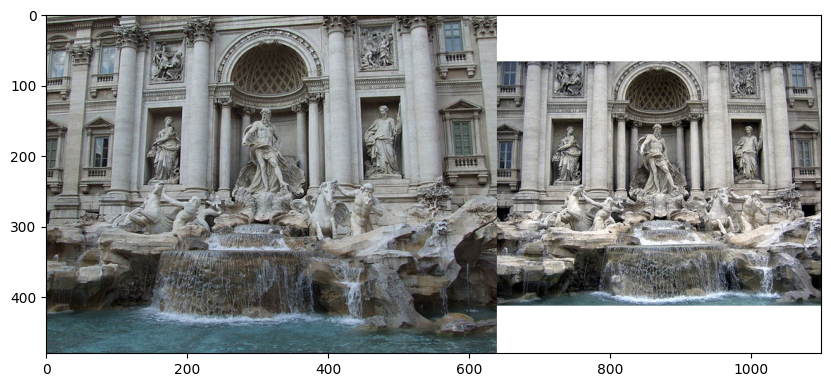

In [2]:
plt.figure(figsize=((10, 5)))
plt.imshow(imageio.imread("../data/L06/trevi_easy.jpg"))
plt.show()

#### Invariance: Hard Mode

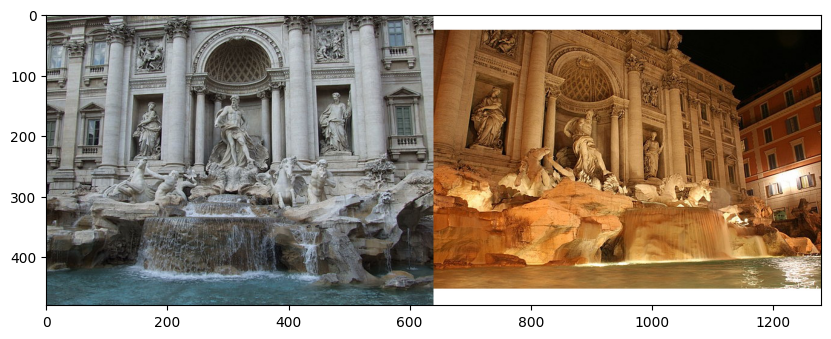

In [3]:
plt.figure(figsize=((10, 5)))
plt.imshow(imageio.imread("../data/L06/trevi_hard.jpg"))
plt.show()

#### Invariance: Mars Mode

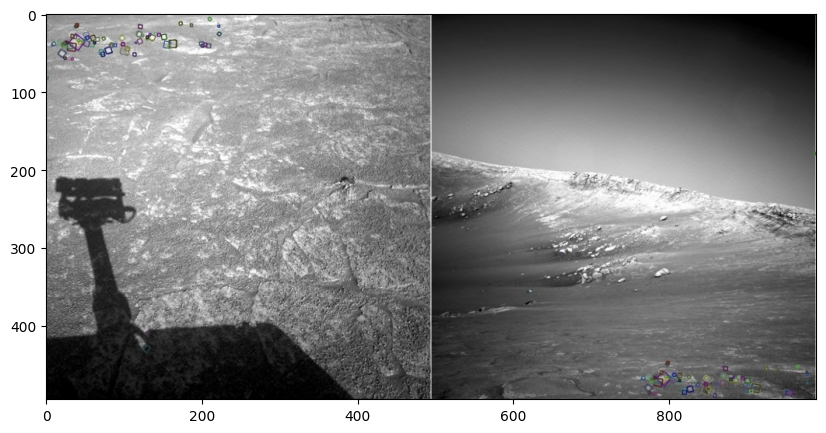

In [4]:
plt.figure(figsize=((10, 5)))
plt.imshow(imageio.imread("../data/L06/mars2.jpg"))
plt.show()

Things we might want to be invariant to (an aspirational list):
* Geometric transformations
    * Translation
    * Scale
    * Rotation
    * All changes in viewpoint
* Photometric transformations
    * Color/intensity shift/scale
    * Contrast adjustment
 
Others that aren't clearly one of the above: motion blur, noise, weather, lighting, occlusion, ...

##### Homework Problem 1
Comment on whether (or the extent to which) the Harris corner detector is robust to each of the following transformations. In other words, which of these will not affect which points will be found as corners by the Harris detector? If the detector is almost but not quite completely robust to a given change, comment on this. Assume edge effects and intensity clipping are not an issue.
1. Intensity shift: $I(x, y)' = I(x, y) + 20$ 
2. Intensity scale: $I(x, y)' = 1.2 I(x, y)$ normailze the intenisity to make it robust
3. Scaling: $I(x, y)' = I(0.5x, 0.5y)$
4. Translation $I(x, y)' = I(x - 10, y)$ 
5. Rotation


### A Mathematical Digression: Geometric Transformations

Notice that I ran out of math in the last subproblem above - how do I write this down? We've reached the point where it becomes nicer to talk about geometric transformations using the language of linear algebra.

Whiteboard linear algebra review:
* A 2x2 matrix is a mapping from points to points
* You can interpret it two ways:
    * Where does it send a point?
    * What coordinate system does it translate points *from*? This is the change-of-basis vew.
* Transformations can compose (they are linear!). If you let M = AB and apply it to x, so Mx = ABx, then B happens first, then A!
    * Sometimes this matters, since matrix multiplication doesn't commute.

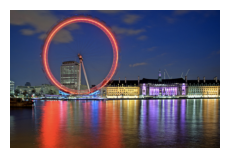

In [5]:
import geometry
ferris = imageio.imread("../data/L06/tx.png").astype(np.float32) / 255
ferris = skim.transform.rescale(ferris[:,:,:3], (0.5, 0.5, 1))

H, W = ferris.shape[:2]
util.imshow_truesize(ferris)
plt.show()

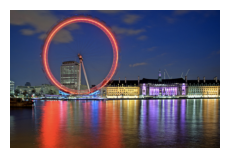

In [6]:
def warp_ferris(tx, **kwargs):
    fw = geometry.warp(ferris, tx, **kwargs)
    util.imshow_truesize(fw)
    plt.show()
    # plt.gca().set_axis_off()

M = np.array([
    [1.0, 0.0],
    [0.0, 1.0]
], dtype=np.float32)

warp_ferris(M, dsize=(W, H))

##### Homework Problems 2-5

**Important note: the coordinate system conventions here differ from the homework! Here, (0, 0) is at the top left and y points down In the HW visualizations, the origin is at the bottom left and y points up.**

2. Scale uniformly by a factor of 1.3:

   ![](../data/L06/tx1.png)

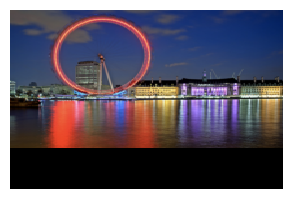

In [14]:
M = np.array([
    [1.3, 0],
    [0.0, 1]
], dtype=np.float32)

warp_ferris(M, dsize=(int(W*1.3), int(H*1.3)))

3. Scale by a factor of 2 in only the $x$ direction:

    ![](../data/L06/tx2.png)

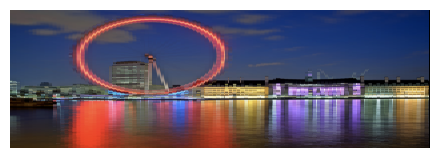

In [16]:
M = np.array([
    [2.0, 0.0],
    [0.0, 1.0]
], dtype=np.float32)

warp_ferris(M, dsize=(W*2, H))

4. Skew or *shear* the image so the top row of pixels is shifted over by 1/4 of the image's height.

    ![](../data/L06/tx3.png)

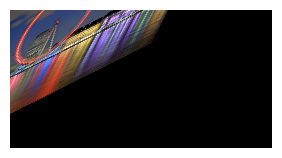

In [29]:
M = np.array([
    [1.0, -.5],
    [0, 1.0]
], dtype=np.float32)

warp_ferris(M, dsize=(int(W*1.25), H))

5. Rotate the image counter-clockwise by 30 degrees:

    ![](../data/L06/tx4.png)

* Rotation matrices: to rotate $\theta$ counter-clockwise, the matrix is:
  $$
  \begin{bmatrix}
  \cos \theta & \sin \theta \\
  -\sin \theta & \cos \theta \\
  \end{bmatrix}
  $$

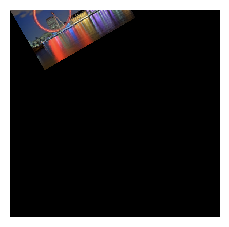

In [10]:
rad30 = np.radians(30)

M = np.array([
    [np.cos(rad30), np.sin(rad30)],
    [-np.sin(rad30), np.cos(rad30)]
], dtype=np.float32)

warp_ferris(M, dsize=(int(W), int(H*1.5)))

6. Translate the image up and right by (say) 40 pixels:
![](../data/L06/tx5.png)

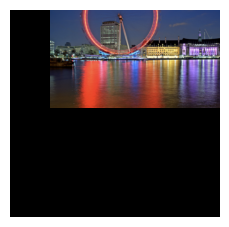

In [36]:
M = np.array([
    [1, 0, 40],
    [0,1, 40],
    [0,0, 1]
], dtype=np.float32)

warp_ferris(M, dsize=(int(W), int(H*1.5)))

It's a trick question. This one's impossible!

Proof: no matrix can move (0, 0) to anywhere but (0, 0).

Hack: add a column! This is the same hack as the bias trick from ML.

Whiteboard: Affine transformations


Just like 2x2 linear transformations can be seen as a change of basis, affine can be seen as a **change of frame**, where the origin may also 
move. This will come back to haunt us later!

### Back to the Features!

For our feature descriptors, we agreed that a patch of pixels is more unique than a single pixel value. Let's start there, and add invariances to the following:

* Rotation
* (some) intensity shifts and scales ($I' = aI + b$, sort of)
* Scale

#### The MOPS Feature descriptor
Multi-scale oriented patches

Rotation: rotate the gradient direction to angle 0 (horizontal, presumably)
Intensity: subtract mean and divide by standard deviation
Scale: run it on a Gaussian pyramid

But how do we even extract a patch in the first place?

(**whiteboard**: patch extraction transformation)

In [ ]:
import features

h = imageio.imread("../data/harris_crop.jpg")
h = skim.color.rgb2gray(h.astype(np.float32) / 255)
corner_mask = features.harris_corners(h, 0.1)
img_and_features = features.overlay_features(h, corner_mask)

plt.imshow(img_and_features)
plt.show()

# print the feature locations to console
# features.get_harris_points(corner_mask).T

In [ ]:
y, x = [59,  32]
util.imshow_gray(features.extract_MOPS(h, (y, x))) 
plt.colorbar()
plt.show()